In [1]:
# Import all libraries required for this model

import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import string
import pandas as pd
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from sklearn.model_selection import train_test_split
import json
import requests
import time
import re
import collections
from warnings import filters
import math

random.seed(42)

In [ ]:
def load_filtered(path):
    words = Path(path).read_text(encoding="utf-8").splitlines()
    return {w for w in words if 5 <= len(w) <= 10 and w.isalpha() and w.islower()}

# Load word lists
wl70 = load_filtered("wl70.txt")
wl60 = load_filtered("wl60.txt")

# Rarer words only in wl70 (not in wl60)
rare_words = wl70 - wl60

# Random 50,000 common words from wl60
sample_size = 50_000
sampled_common = set(random.sample(list(wl60), sample_size))

# Final training set = rare + sampled common
train_words = rare_words | sampled_common

# Test set = remaining common words
test_words = wl60 - sampled_common

# Sanity checks
print(f"Rare words: {len(rare_words)}")
print(f"Sampled common words: {len(sampled_common)}")
print(f"Final train set: {len(train_words)}")
print(f"Final test set: {len(test_words)}")
assert train_words.isdisjoint(test_words)

# Save to files
Path("hangman_train.txt").write_text("\n".join(sorted(train_words)))
Path("hangman_test.txt").write_text("\n".join(sorted(test_words)))


Rare words: 34283
Sampled common words: 50000
Final train set: 84283
Final test set: 8004


69998

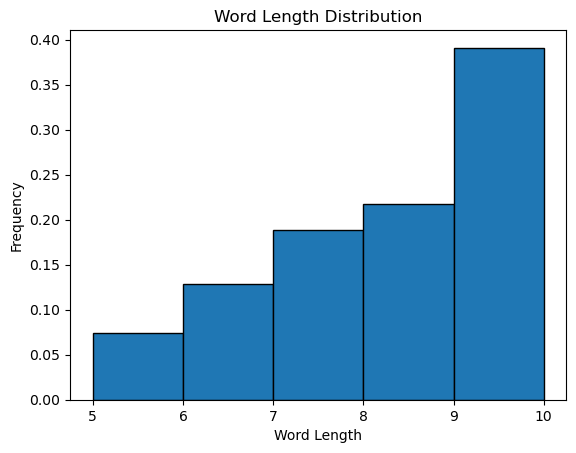

Mean: 7.90
Min: 5.00
Max: 10.00


In [ ]:
# Understand the word length distribution of the dictionary by looking at the histogram

word_lens = [len(word) for word in train_words]

plt.hist(word_lens, bins=range(min(word_lens), max(word_lens) + 1), edgecolor='black', density=True)
plt.title('Word Length Distribution')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

print(f'Mean: {np.mean(word_lens):.2f}')
print(f'Min: {np.min(word_lens):.2f}')
print(f'Max: {np.max(word_lens):.2f}')

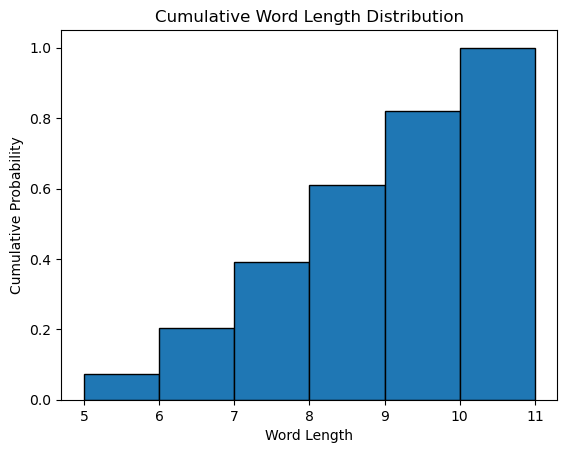

In [ ]:
# Understand the word length distribution of the dictionary by looking at the cumulative histogram

plt.hist(word_lens, bins=range(min(word_lens), max(word_lens) + 2), edgecolor='black', cumulative=True, density=True)
plt.title('Cumulative Word Length Distribution')
plt.xlabel('Word Length')
plt.ylabel('Cumulative Probability')
plt.show()

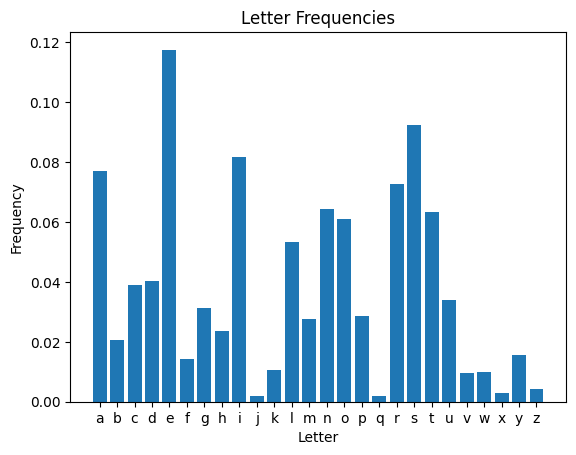

In [7]:
# Understand the letter frequencies in the dictionary

all_letters = sorted(''.join(words_train))
letter_counts = Counter(all_letters)
total_letters = sum(letter_counts.values())
letter_freq = {
    letter: count / total_letters
    for letter, count in letter_counts.items()
    if letter in string.ascii_lowercase}

plt.bar(letter_freq.keys(), letter_freq.values())
plt.title('Letter Frequencies')
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.show()

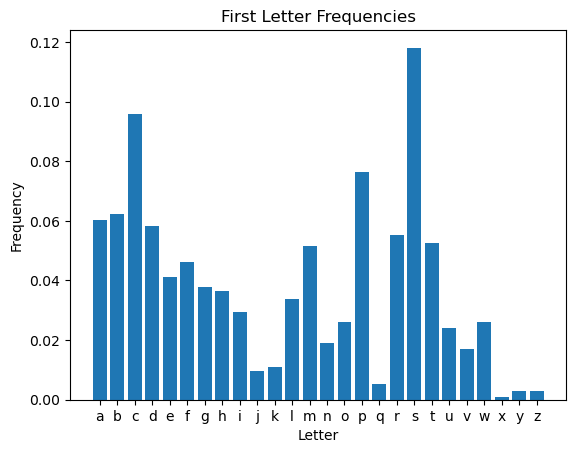

In [ ]:
# Review the first letter frequencies

first_letters = [word[0] for word in train_words]
first_letter_counts = Counter(first_letters)
total_first = sum(first_letter_counts.values())
first_letter_freq = {
    letter: count / total_first
    for letter, count in sorted(first_letter_counts.items())
}

plt.bar(first_letter_freq.keys(), first_letter_freq.values())
plt.title('First Letter Frequencies')
plt.xlabel('Letter')
plt.ylabel('Frequency')
plt.show()

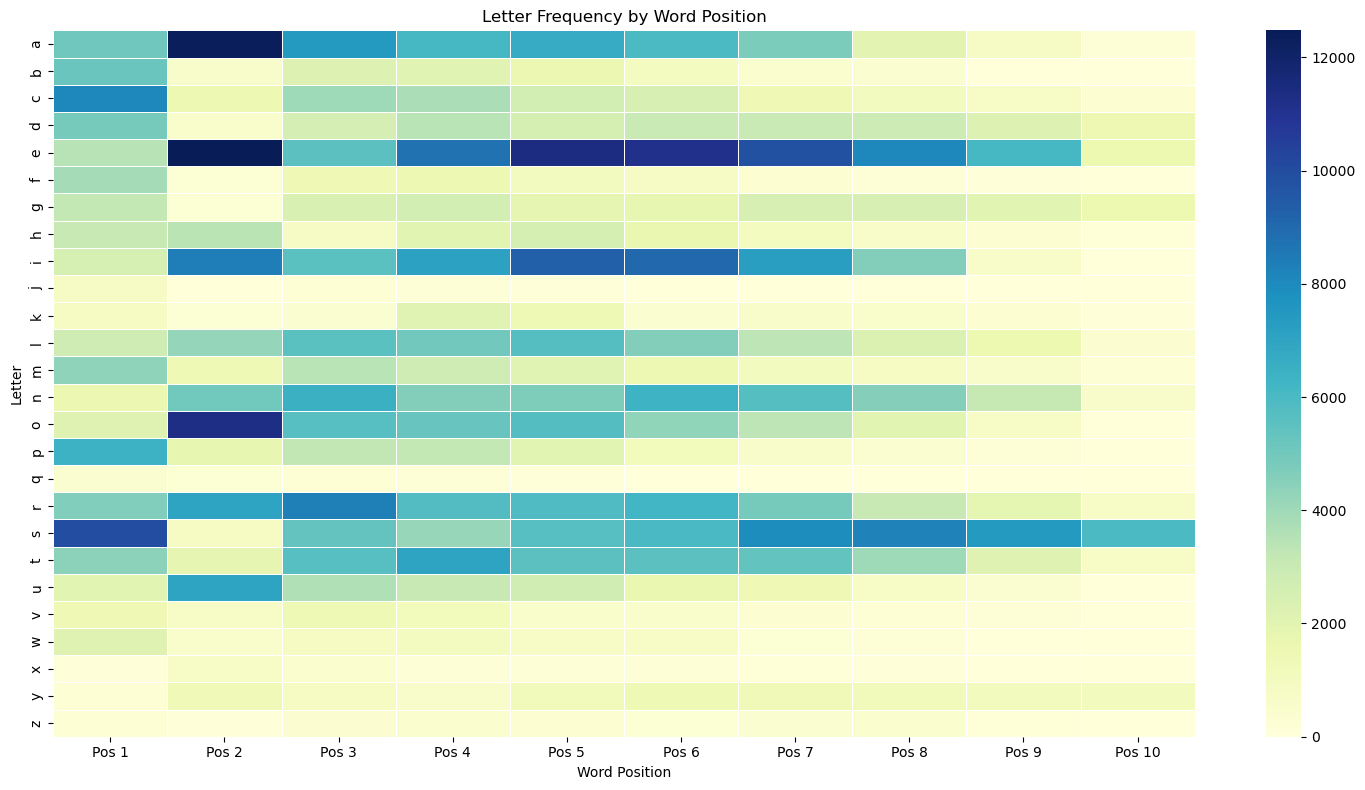

In [ ]:
# Create a heatmap of letter frequencies by the position in a word

max_length = max(len(word) for word in train_words)
alphabet = list(string.ascii_lowercase)

positions_count = {
    letter: [0] * max_length
    for letter in alphabet
}

for word in train_words:
    for i, letter in enumerate(word):
        if letter in positions_count and i < max_length:
            positions_count[letter][i] += 1

heatmap_df = pd.DataFrame(positions_count).T
heatmap_df.columns = [f"Pos {i+1}" for i in range(max_length)]

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_df, cmap='YlGnBu', linewidths=0.5)
plt.title('Letter Frequency by Word Position')
plt.xlabel('Word Position')
plt.ylabel('Letter')
plt.tight_layout()
plt.show()

In [8]:
# Get the guess order and frequency to use in the model later

guess_order = sorted(letter_freq, key=letter_freq.get, reverse=True)
guess_freq = {letter: letter_freq[letter] for letter in guess_order}
guess_freq

{'e': 0.1175169493434241,
 's': 0.09242216065650082,
 'i': 0.0817352523819177,
 'a': 0.07717338258591046,
 'r': 0.07275266346825236,
 'n': 0.06424307948735275,
 't': 0.06347726197716062,
 'o': 0.061044665180079734,
 'l': 0.053326425959711994,
 'd': 0.04023845455023237,
 'c': 0.03906870584348792,
 'u': 0.03410891126277301,
 'g': 0.031182287091470143,
 'p': 0.028631063660457538,
 'm': 0.027730101883760915,
 'h': 0.0234640478711024,
 'b': 0.02069809521664377,
 'y': 0.01571877979743376,
 'f': 0.014406378809379013,
 'k': 0.01061783453836971,
 'w': 0.00980847054230391,
 'v': 0.00963578620177039,
 'z': 0.00413241134911518,
 'x': 0.003072279658535487,
 'j': 0.00197911270281025,
 'q': 0.0018154379800436966}

In [ ]:
# What is the proportion of vowels and consonants in the dictionary

vowels = set('aeiou')
vowel_count = sum(letter_counts[vowel] for vowel in vowels)
consonant_count = total_letters - vowel_count

print(f'Vowel %: {vowel_count / total_letters:.2%}')
print(f'Consonant %: {consonant_count / total_letters:.2%}')

Vowel %: 37.16%
Consonant %: 62.84%


In [9]:
# Function to get the k most commom n-grams

def get_top_ngrams(words, n=2, top_k=20):

    ngram_counts = Counter()
    for word in words:
        word = word.lower()
        for letter in range(len(word) - n + 1):
            ngram = word[letter : letter + n]
            ngram_counts[ngram] += 1

    return ngram_counts.most_common(top_k)

In [10]:
# Get the top 20 bigrams and top 15 trigrams to use later in the transformer

top_bigrams = get_top_ngrams(words_train, n=2, top_k=20)
top_trigrams = get_top_ngrams(words_train, n=3, top_k=15)
top_ngrams = [ngram for (ngram, _) in top_bigrams] + [ngram for (ngram, _) in top_trigrams]
top_ngrams

['in',
 'er',
 'es',
 'ed',
 'ng',
 'te',
 're',
 'st',
 'le',
 'at',
 'ti',
 'an',
 'en',
 'ri',
 'ar',
 'on',
 'li',
 'ra',
 'al',
 'or',
 'ing',
 'ers',
 'ate',
 'ter',
 'ies',
 'est',
 'tin',
 'ine',
 'lin',
 'ent',
 'nes',
 'ess',
 'ted',
 'ion',
 'ati']

In [ ]:
# Create the function which predicts the next letter based on some type of model

def predict_letter_with_heuristics(hangman_str, guessed_letters, words_list):
    #print('Heuristics')
    if len(guessed_letters) == 0:
        return 'e'
    else:
        possible_words = []
        for word in words_list:
            valid_word = True
            if len(hangman_str) != len(word):
                continue
            else:
                for i, letter in enumerate(word):
                    if hangman_str[i] != '_' and hangman_str[i] != word[i]:
                        valid_word = False
                        break
                    elif hangman_str[i] == '_' and word[i] in guessed_letters:
                        valid_word = False
                        break
            if valid_word:
                possible_words.append(word)
        letter_counts = Counter()
        for word in possible_words:
            masked_letters = set()
            for i, letter in enumerate(word):
                if hangman_str[i] == '_' and letter not in guessed_letters:
                    masked_letters.add(letter)
            for letter in masked_letters:
                letter_counts[letter] += 1
        total_letters = sum(letter_counts.values())
        letter_freq = {
            letter: count / total_letters
            for letter, count in letter_counts.items()
            if letter in string.ascii_lowercase and letter not in guessed_letters
            }
        if not letter_freq:
            return random.choice([letter for letter in string.ascii_lowercase if letter not in guessed_letters])
        best_guess = sorted(letter_freq, key=letter_freq.get, reverse=True)[0]
        return best_guess

In [ ]:
predict_letter_with_heuristics('p_an__', set('anpzt'), train_words)

'e'

In [ ]:
# Create a Hangman game design to be used for testing

def play_hangman_games(hangman_word_list, words_train, max_lives=6):

    wins = 0
    for word in hangman_word_list:
        hangman_result, hangman_word, wrong_guesses, guessed_letters = play_single_hangman(word, words_train, max_lives)
        if hangman_result == 1:
            print(f'Win: {word} with {max_lives - wrong_guesses} lives remaining!')
        else:
            print(f'Loss: {word} with output being {hangman_word} and guesses {guessed_letters}')
        wins += hangman_result
    return wins

def play_single_hangman(guess_word, words_list, max_lives=6):

    hangman_word = ['_' for _ in guess_word]
    wrong_guesses = 0
    guessed_letters = set()
    while '_' in hangman_word and wrong_guesses < max_lives:
        hangman_str = ''.join(hangman_word)
        next_guess = predict_letter_with_heuristics(hangman_str, guessed_letters, words_list)
        guessed_letters.add(next_guess)
        if next_guess in guess_word:
            for i, letter in enumerate(guess_word):
                if letter == next_guess:
                    hangman_word[i] = next_guess
        else:
            wrong_guesses += 1
    return int('_' not in hangman_word), hangman_word, wrong_guesses, guessed_letters

In [ ]:
num_games = 100
max_lives = 6
heuristics_test = random.sample(list(test_words), num_games)
num_wins = play_hangman_games(heuristics_test, train_words, max_lives)
print(f'Win rate of {num_wins / num_games:.1%}')

Win: tattered with 2 lives remaining!
Win: breasted with 1 lives remaining!
Loss: nitro with output being ['n', 'i', '_', '_', 'o'] and guesses {'o', 'n', 'i', 'q', 'l', 'y', 'e', 's', 'a'}
Loss: killer with output being ['_', 'i', '_', '_', 'e', 'r'] and guesses {'n', 'i', 'b', 't', 'r', 'e', 's', 'a', 'd'}
Loss: masterwork with output being ['_', 'a', 's', 't', 'e', '_', '_', 'o', '_', 'k'] and guesses {'o', 'n', 'j', 'i', 't', 'v', 'e', 'g', 'x', 's', 'a', 'k'}
Win: escapist with 2 lives remaining!
Loss: kinswoman with output being ['_', 'i', 'n', 's', '_', '_', '_', '_', 'n'] and guesses {'n', 'f', 'i', 'b', 't', 'e', 'x', 's', 'z'}
Loss: scrip with output being ['s', '_', 'r', 'i', 'p'] and guesses {'o', 'i', 'b', 't', 'r', 'e', 'p', 'h', 's', 'a'}
Loss: anorectic with output being ['a', 'n', '_', '_', 'e', '_', '_', 'i', '_'] and guesses {'n', 'f', 'i', 'q', 'b', 'e', 'g', 'm', 's', 'a'}
Loss: wingtips with output being ['_', 'i', 'n', '_', 't', 'i', '_', 's'] and guesses {'o', '

In [2]:
# Read in the training dictionary

words_train = []
dictionary_file = 'hangman_train.txt'
with open(dictionary_file, 'r') as file:
    for line in file:
        word = line.strip().lower()
        if word.isalpha():
            words_train.append(word)

print(words_train[:10])
print(f'Total Training Dataset: {len(words_train)}')

['aalii', 'aaliis', 'aardvarks', 'aardwolf', 'aardwolves', 'abaca', 'abacas', 'abacus', 'abacuses', 'abaft']
Total Training Dataset: 84283


In [3]:
# Read in the test dictionary

words_test = []
dictionary_file = 'hangman_test.txt'
with open(dictionary_file, 'r') as file:
    for line in file:
        word = line.strip().lower()
        if word.isalpha():
            words_test.append(word)

print(words_test[:10])
print(f'Total Training Dataset: {len(words_test)}')

['aardvark', 'aback', 'abalone', 'abandon', 'abattoir', 'abbes', 'abbrev', 'abeyance', 'ablates', 'ablations']
Total Training Dataset: 8004


In [4]:
def generate_masked_samples(words, guess_order, num_permutations):

    """
    Generates masked-word samples for a Hangman-style next-letter prediction task.

    For each input word, the function creates multiple partially masked versions of the word.
    Each sample includes:
        - a masked version of the word,
        - the next correct letter to guess,
        - and the original word (for feature engineering, not be fed to the model).

    Inputs:
    -------
    words : list of str
        List of words to generate training samples from.
    guess_order : str
        String of letters indicating the order in which guesses are made (frequency-based from training dataset).
    num_permutations : int
        Each permutation masks all unique letters in a random order. This process is repeated num_permutations times to increase sample diversity.

    Ouputs:
    -------
    dict_samples : list of dicts
    Each dict contains:
        - 'current_state' : masked word (str)
        - 'next_guess' : list of correct letters still hidden (list of str)
        - 'original_word' : full word (str)
    """

    # Initialise the output as an empty list
    all_samples = []

    for word in words:
        # Use fixed seed for reproducibility
        rng = np.random.default_rng(42)
        # Filter guess_order to only letters present in the word
        guess_order_word = [c for c in guess_order if c in set(word)]
        # Initialise samples generated for this particular word
        samples_word = []
        # Random masking phase
        for _ in range(num_permutations):
            masked_word = word
            # Randomly permute the unique letters in the word
            for letter in rng.permuted(list(set(word))):
                # Mask one letter at a time
                masked_word = masked_word.replace(letter, '_')
                # Determine all remaining letters still hidden
                remaining_letters = [letter for letter in guess_order_word if letter in set(word) and letter not in masked_word]
                if remaining_letters:
                    samples_word.append((masked_word, remaining_letters, word))
            masked_word = word  # Reset for deterministic phase
        # Deterministic masking using reversed guess order
        for letter in reversed(guess_order_word):
            masked_word = masked_word.replace(letter, '_')
            remaining_letters = [letter for letter in guess_order_word if letter in set(word) and letter not in masked_word]
            if remaining_letters:
                samples_word.append((masked_word, remaining_letters, word))
        # Remove duplicate samples
        seen_samples = set()
        for masked, letters, full_word in samples_word:
            key = (masked, tuple(sorted(letters)))
            if key not in seen_samples:
                all_samples.append({
                    'current_state': masked,
                    'next_guesses': letters,
                    'original_word': full_word
                })
                seen_samples.add(key)

    return all_samples


In [11]:
generate_masked_samples(['apple'], guess_order, 6)

[{'current_state': '_pple', 'next_guesses': ['a'], 'original_word': 'apple'},
 {'current_state': '_pp_e',
  'next_guesses': ['a', 'l'],
  'original_word': 'apple'},
 {'current_state': '_pp__',
  'next_guesses': ['e', 'a', 'l'],
  'original_word': 'apple'},
 {'current_state': '_____',
  'next_guesses': ['e', 'a', 'l', 'p'],
  'original_word': 'apple'},
 {'current_state': '____e',
  'next_guesses': ['a', 'l', 'p'],
  'original_word': 'apple'},
 {'current_state': 'a__le', 'next_guesses': ['p'], 'original_word': 'apple'},
 {'current_state': '___le',
  'next_guesses': ['a', 'p'],
  'original_word': 'apple'},
 {'current_state': 'app_e', 'next_guesses': ['l'], 'original_word': 'apple'},
 {'current_state': 'appl_', 'next_guesses': ['e'], 'original_word': 'apple'},
 {'current_state': 'a__l_',
  'next_guesses': ['e', 'p'],
  'original_word': 'apple'},
 {'current_state': 'a____',
  'next_guesses': ['e', 'l', 'p'],
  'original_word': 'apple'},
 {'current_state': 'a___e',
  'next_guesses': ['l', 'p

In [12]:
def generate_features(masked_samples, guess_order, guess_freq, ngram_list, max_lives=6, inference=False):

    """
    Generate a list of feature dictionaries from masked samples.

    Each sample consists of:
        - 'current_state': the current masked word (e.g., 'b_n_n_')
        - 'next_guesses' (not available during inference): the next letters to be predicted (e.g. 'e', 'a', etc.)
        - 'original_word' (not available during inference): the true word from which the masked state was derived (e.g. 'banana')
        - 'guess_history' (only available during inference)

    Features include:
        - Length and structure of the word and mask
        - Masked letter indices and prefix/suffix lengths
        - Simulated correct/incorrect guess history and related stats
        - Vowel/consonant breakdowns
        - Letter repetition, revealed chunks, and presence of common n-grams

    Inputs:
    -------
    masked_samples: dict or list of dicts
        The input samples, either as a single dictionary or a list of dictionaries.
    guess_order: str
        The order in which letters are guessed (e.g., 'etaoinshrdluc...').
    max_lives: int, default=6
        The maximum number of incorrect guesses allowed.
    inference: boolean, default=False
        Is the model being called pre-training or during inference

    Outputs:
    --------
    all_features: list of dict
        A list of dictionaries, each containing engineered features for one sample.
    """

    all_features = []

    # Define vowels and consonants
    vowels = set('aeiou')
    consonants = set(string.ascii_lowercase) - vowels

    # If only one sample is given as a dict, wrap it in a list
    if isinstance(masked_samples, dict):
        masked_samples = [masked_samples]

    # Iterate over each sample
    for sample in masked_samples:

        if inference:
            assert 'guess_history' in sample
        else:
            assert 'next_guesses' in sample and 'original_word' in sample

        current_state = sample['current_state']
        state_set =set(current_state)

        if inference:
            guess_history = sample['guess_history']
            correct_guesses = [letter for letter in guess_history if letter in state_set]
            incorrect_guesses = [letter for letter in guess_history if letter not in correct_guesses]
        else:
            next_guesses = sample['next_guesses']
            original_word = sample['original_word']
            # If not inference, we need to 'simulate' a guess history
            correct_guesses = state_set - {'_'}
            # If word is fully masked, pretend like you have guessed some so you still get incorrect guesses sometimes
            if random.random() < 0.8:
                min_guesses = random.randint(1, 5)
            else:
                min_guesses = 0
            # Construct a plausible guess history until all correct letters are guessed
            guess_history = []
            for letter in guess_order:
                if set(guess_history) >= correct_guesses and len(guess_history) >= min_guesses:
                    break
                guess_history.append(letter)
            # Identify incorrect guesses based on the guess history
            possible_incorrects = [letter for letter in guess_history if letter not in set(original_word)]
            # Randomly sample incorrect guesses to simulate guess limit
            sample_size = min(len(possible_incorrects), random.randint(0, max_lives))
            incorrect_guesses = random.sample(possible_incorrects, k=sample_size)
            # Calculate in-word letter frequencies to add to the labels
            letter_counts = Counter(original_word)
            total_count = sum(letter_counts[letter] for letter in next_guesses)
            label_weights = {letter: letter_counts[letter] / total_count for letter in next_guesses}

        total_correct = len(correct_guesses)
        total_incorrect = len(incorrect_guesses)
        lives_remaining = max(max_lives - len(incorrect_guesses), 0)

        # Basic word structure
        word_length = len(current_state)
        num_masked = current_state.count('_')

        # Get the location of the first and last masked letter
        first_masked_idx = current_state.find('_')
        last_masked_idx = current_state.rfind('_')

        # Get the number of contiguous masked sequences and their average length
        mask_blocks = re.findall(r'_+', current_state)
        num_masked_blocks = len(mask_blocks)
        avg_masked_block_len = sum(len(block) for block in mask_blocks) / num_masked_blocks if num_masked_blocks > 0 else 0

        # Get the average frequency of the remaining unguessed letters
        unguessed = set(string.ascii_lowercase) - set(guess_history)
        remaining_freqs = [guess_freq[letter] for letter in unguessed]
        avg_remaining_freq = sum(remaining_freqs) / len(remaining_freqs) if remaining_freqs else 0
        avg_remaining_freq /= max(guess_freq.values())

        # Binary list: 1 = masked, 0 = revealed
        masked_idx = [1 if letter == '_' else 0 for letter in current_state]

        # Get mask entropy feature
        total = sum(masked_idx)
        if total == 0 or total == len(masked_idx):
            masked_entropy = 0
        else:
            p = total / len(masked_idx)
            masked_entropy = - (p * math.log2(p) + (1 - p) * math.log2(1 - p))

        # Prefix: how many '_' at the start
        masked_prefix_len = 0
        for letter in current_state:
            if letter == '_':
                masked_prefix_len += 1
            else:
                break

        # Suffix: how many '_' at the end
        masked_suffix_len = 0
        for letter in reversed(current_state):
            if letter == '_':
                masked_suffix_len += 1
            else:
                break

        # Split correct/incorrect guesses by vowels and consonants
        correct_vowels = [letter for letter in correct_guesses if letter in vowels]
        correct_consonants = [letter for letter in correct_guesses if letter in consonants]
        incorrect_vowels = [letter for letter in incorrect_guesses if letter in vowels]
        incorrect_consonants = [letter for letter in incorrect_guesses if letter in consonants]

        num_correct_vowels = len(correct_vowels)
        num_correct_consonants = len(correct_consonants)
        num_incorrect_vowels = len(incorrect_vowels)
        num_incorrect_consonants = len(incorrect_consonants)

        # Repetition and revealed chunks
        revealed_letters = [letter for letter in current_state if letter != '_']
        revealed_counts = Counter(revealed_letters)
        num_repeated_letters = sum(1 for letter, count in revealed_counts.items() if count > 1)
        num_contiguous_letters = len(re.findall(r'[a-zA-Z]+', current_state))

        # Count common n-grams (top 20 bigrams and top 15 trigrams from training dictionary) in current state
        ngram_counts = {}
        for ngram in ngram_list:
            ngram_count = current_state.count(ngram)
            if ngram_count > 0:
                ngram_counts[ngram] = ngram_count

        # Final dictionary of features for this sample
        features = {
            'current_state': current_state,
            'word_length': word_length,
            'num_masked': num_masked,
            'first_masked_idx': first_masked_idx,
            'last_masked_idx': last_masked_idx,
            'num_masked_blocks': num_masked_blocks,
            'avg_masked_block_len': avg_masked_block_len,
            'avg_remaining_freq': avg_remaining_freq,
            'masked_entropy': masked_entropy,
            'masked_idx': masked_idx,
            'masked_prefix_len': masked_prefix_len,
            'masked_suffix_len': masked_suffix_len,
            'total_correct_guesses': total_correct,
            'total_incorrect_guesses': total_incorrect,
            'lives_remaining': lives_remaining,
            'correct_vowels': correct_vowels,
            'correct_consonants': correct_consonants,
            'incorrect_vowels': incorrect_vowels,
            'incorrect_consonants': incorrect_consonants,
            'num_correct_vowels': num_correct_vowels,
            'num_correct_consonants': num_correct_consonants,
            'num_incorrect_vowels': num_incorrect_vowels,
            'num_incorrect_consonants': num_incorrect_consonants,
            'num_repeated_letters': num_repeated_letters,
            'num_contiguous_letters': num_contiguous_letters,
            'ngram_counts': ngram_counts
        }

        if not inference:
            features['next_guesses'] = label_weights

        # Store result
        all_features.append(features)

    return all_features


In [21]:
def encode_features(features, vocab, ngram_list, max_lives=6, max_len=10, inference=False):
    """
    Optimized version: Reduces memory overhead while maintaining same input/output structure.
    """

    encoded = []

    if isinstance(features, dict):
        features = [features]  # Wrap single input into a list

    # Predefine keys to flatten multi-hot features in order
    char_keys = ['correct_vowels', 'correct_consonants', 'incorrect_vowels', 'incorrect_consonants']

    for feature in features:
        # 1. Tokenize and pad current state
        current_state = [
            vocab['[MASK]'] if letter == '_' else vocab[letter]
            for letter in feature['current_state']
        ]
        current_state = pad_sequences([current_state], maxlen=max_len, padding='post', value=vocab['[PAD]'])[0]

        # 2. Masked index vector
        masked_idx = pad_sequences([feature['masked_idx']], maxlen=max_len, padding='post', value=0)[0]

        # 3. Scalar features
        wl = max(1, feature['word_length'])
        nf = feature
        norm_features = [
            wl / max_len,
            1 - nf['num_masked'] / wl,
            nf['first_masked_idx'] / wl,
            nf['last_masked_idx'] / wl,
            nf['num_masked_blocks'] / wl,
            nf['avg_masked_block_len'] / wl,
            nf['avg_remaining_freq'],
            nf['masked_entropy'],
            nf['lives_remaining'] / max_lives,
            nf['masked_prefix_len'] / wl,
            nf['masked_suffix_len'] / wl,
            nf['total_correct_guesses'] / max_lives,
            nf['total_incorrect_guesses'] / max_lives,
            nf['num_correct_vowels'] / 5,
            nf['num_incorrect_vowels'] / 5,
            nf['num_correct_consonants'] / 21,
            nf['num_incorrect_consonants'] / 21,
            nf['num_repeated_letters'] / wl,
            nf['num_contiguous_letters'] / wl
        ]

        # 4. Flattened multi-hot character features
        char_multi_hot = []
        for key in char_keys:
            vec = [0] * 26
            for letter in feature[key]:
                idx = ord(letter) - ord('a')
                vec[idx] = 1
            char_multi_hot.extend(vec)

        # 5. Normalized n-gram frequency vector
        ngram_counts = [feature['ngram_counts'].get(ngram, 0) for ngram in ngram_list]
        total = sum(ngram_counts) or 1
        ngram_vector = [count / total for count in ngram_counts]

        # 6. Build output sample
        output = {
            'input_ids': current_state,
            'masked_idx': masked_idx,
            'norm_features': norm_features,
            'char_multi_hot': char_multi_hot,
            'ngram_vector': ngram_vector
        }

        # 7. Weighted label
        if not inference:
            label = [0.0] * 26
            for letter, weight in feature['next_guesses'].items():
                idx = ord(letter) - ord('a')
                label[idx] = weight
            output['label'] = label

        encoded.append(output)

    return encoded

In [22]:
class HangmanDataset(Dataset):
    def __init__(self, encoded, max_len=10, inference=False):
        self.encoded = encoded
        self.max_len = max_len
        self.inference = inference

    def __len__(self):
        return len(self.encoded)

    def __getitem__(self, idx):
        sample = self.encoded[idx]

        output = {
            'input_ids': torch.tensor(sample['input_ids'], dtype=torch.long),
            'masked_idx': torch.tensor(sample['masked_idx'], dtype=torch.long),
            'norm_features': torch.tensor(sample['norm_features'], dtype=torch.float),
            'char_multi_hot': torch.tensor(sample['char_multi_hot'], dtype=torch.float),
            'ngram_vector': torch.tensor(sample['ngram_vector'], dtype=torch.float)
        }

        if not self.inference:
            output['label'] = torch.tensor(sample['label'], dtype=torch.float)

        return output

In [24]:
class HangmanTransformer(nn.Module):

    def __init__(self, vocab_size=28, max_len=10, d_model=256, nhead=4, num_layers=4,
                 dim_feedforward=512, dropout=0.1, ngram_dim=35, aux_dim=19):
        super(HangmanTransformer, self).__init__()

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.embedding_dropout = nn.Dropout(dropout)  # Token dropout

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.aux_mlp = nn.Sequential(
            nn.Linear(aux_dim + 26 * 4 + ngram_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, d_model)
        )

        self.cls_head = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 26)
        )

    def forward(self, input_ids, masked_idx, norm_features, char_multi_hot, ngram_vector):

        # Positional encoding
        batch_size, seq_len = input_ids.size()
        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)

        token_emb = self.token_embedding(input_ids)
        pos_emb = self.position_embedding(positions)
        x = self.embedding_dropout(token_emb + pos_emb)

        x = x.transpose(0, 1)  # Transformer expects seq_len x batch x embed
        transformer_output = self.transformer_encoder(x)
        x = transformer_output.transpose(0, 1)  # Back to batch x seq_len x embed

        # Masked token representation
        masked_idx = masked_idx.bool()
        masked_token_emb = (x * masked_idx.unsqueeze(-1)).sum(dim=1) / masked_idx.sum(dim=1, keepdim=True).clamp(min=1)

        # Flatten and combine auxiliary features
        aux_features = torch.cat([
            norm_features,
            char_multi_hot,
            ngram_vector
        ], dim=1)
        aux_emb = self.aux_mlp(aux_features)

        # Final classifier input: [masked_token_emb || aux_emb]
        cls_input = torch.cat([masked_token_emb, aux_emb], dim=1)
        logits = self.cls_head(cls_input)

        return logits


In [25]:
# Use the guess order and ngram list (generated from the training dictionary)
ngram_list = top_ngrams

# Map: MASK -> 0, PAD -> 1, 'a' -> 2, ..., 'z' -> 27
special_tokens = ['[PAD]', '[MASK]']
alphabet = list(string.ascii_lowercase)
all_tokens = special_tokens + alphabet
vocab = {letter: index for index, letter in enumerate(all_tokens)}

# Inverse for predictions
reverse_vocab = {index: letter for letter, index in vocab.items()}

In [26]:
masked_samples = generate_masked_samples(words_train, guess_order, 6)

In [27]:
len(masked_samples)

2877933

In [28]:
features = generate_features(masked_samples, guess_order, guess_freq, ngram_list)

In [29]:
encoded_features = encode_features(features, vocab, ngram_list)

In [30]:
len(encoded_features)

2877933

In [ ]:
import pickle
with open('encoded_features.pkl', 'wb') as f:
    pickle.dump(encoded_features, f)

In [ ]:
import pickle
with open('encoded_features.pkl', 'rb') as f:
    encoded_features = pickle.load(f)

In [31]:
# Split features into training and validation data
train_data, val_data = train_test_split(encoded_features, test_size=0.3, random_state=42)

# Initialise the HangmanDataset class
train_dataset = HangmanDataset(train_data, inference=False)
val_dataset = HangmanDataset(val_data, inference=False)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HangmanTransformer().to(device)
optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss()

best_val_acc = 0.0
best_model_state = None
patience = 2
epochs_without_improvement = 0
num_epochs = 15

for epoch in range(num_epochs):

    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        masked_idx = batch['masked_idx'].to(device)
        norm_features = batch['norm_features'].to(device)
        char_multi_hot = batch['char_multi_hot'].to(device)
        ngram_vector = batch['ngram_vector'].to(device)
        labels = batch['label'].to(device)

        logits = model(
            input_ids=input_ids,
            masked_idx=masked_idx,
            norm_features=norm_features,
            char_multi_hot=char_multi_hot,
            ngram_vector=ngram_vector
        )

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct_train += ((preds == labels).float().sum().item())
        total_train += labels.numel()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():

        for batch in val_loader:

            input_ids = batch['input_ids'].to(device)
            masked_idx = batch['masked_idx'].to(device)
            norm_features = batch['norm_features'].to(device)
            char_multi_hot = batch['char_multi_hot'].to(device)
            ngram_vector = batch['ngram_vector'].to(device)
            labels = batch['label'].to(device)

            logits = model(
                input_ids=input_ids,
                masked_idx=masked_idx,
                norm_features=norm_features,
                char_multi_hot=char_multi_hot,
                ngram_vector=ngram_vector
            )

            loss = criterion(logits, labels)

            total_val_loss += loss.item()
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct_val += ((preds == labels).float().sum().item())
            total_val += labels.numel()

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
        torch.save(best_model_state, 'hangman_transformer.pt')
        print(f"✅ Best model saved at epoch {epoch+1}")
    else:
        epochs_without_improvement += 1
        print(f"⚠️  No improvement for {epochs_without_improvement} epoch(s)")
        if epochs_without_improvement >= patience:
            print("🛑 Early stopping triggered.")
            break

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 | Train Loss: 0.1296 | Train Acc: 0.8608 | Val Loss: 0.1184 | Val Acc: 0.8617
✅ Best model saved at epoch 1
Epoch 2 | Train Loss: 0.1186 | Train Acc: 0.8617 | Val Loss: 0.1154 | Val Acc: 0.8620
✅ Best model saved at epoch 2
Epoch 3 | Train Loss: 0.1163 | Train Acc: 0.8620 | Val Loss: 0.1137 | Val Acc: 0.8623
✅ Best model saved at epoch 3
Epoch 4 | Train Loss: 0.1149 | Train Acc: 0.8621 | Val Loss: 0.1125 | Val Acc: 0.8624
✅ Best model saved at epoch 4
Epoch 5 | Train Loss: 0.1139 | Train Acc: 0.8623 | Val Loss: 0.1117 | Val Acc: 0.8625
✅ Best model saved at epoch 5
Epoch 6 | Train Loss: 0.1131 | Train Acc: 0.8624 | Val Loss: 0.1110 | Val Acc: 0.8626
✅ Best model saved at epoch 6
Epoch 7 | Train Loss: 0.1125 | Train Acc: 0.8625 | Val Loss: 0.1105 | Val Acc: 0.8627
✅ Best model saved at epoch 7
Epoch 8 | Train Loss: 0.1120 | Train Acc: 0.8626 | Val Loss: 0.1100 | Val Acc: 0.8628
✅ Best model saved at epoch 8
Epoch 9 | Train Loss: 0.1115 | Train Acc: 0.8626 | Val Loss: 0.1095 | Va

KeyboardInterrupt: 

In [33]:
model = HangmanTransformer().to(device)
model.load_state_dict(torch.load('hangman_transformer.pt'))
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


HangmanTransformer(
  (token_embedding): Embedding(28, 256)
  (position_embedding): Embedding(10, 256)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (aux_mlp): Sequential(
    (0): Linear(in_features=158, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, 

In [ ]:
def predict_next_letter(current_state, guessed_letters, model, vocab, guess_freq, ngram_list, max_len=10,
                        device='cuda'):

    """
    Predict the next best letter to guess using the trained HangmanTransformer.

    Inputs:
    -------
    current_state: str
        The current masked word state (e.g. "_la_e_").
    guessed_letters: list of str
        Letters already guessed (e.g. ['e', 'a', 'l']).
    model: torch.nn.Module
        Trained HangmanTransformer model.
    vocab: dict
        Mapping from characters (and special tokens) to indices.
    reverse_vocab: dict
        Mapping from indices back to characters.
    ngram_list: list of str
        N-grams used during training for feature extraction.
    max_len: int
        Maximum sequence length the model was trained with.
    device: str
        'cuda' or 'cpu'.
    threshold: float
        Minimum probability for a letter to be considered for prediction.

    Outputs:
    --------
    str
        The predicted next best letter.
    """

    # Step 1: Build sample
    sample = {
        'current_state': current_state,
        'guess_history': guessed_letters
    }

    # Step 2: Feature generation and encoding
    features = generate_features(sample, guess_order=None, guess_freq=guess_freq, ngram_list=ngram_list, max_lives=6, inference=True)
    encoded = encode_features(features, vocab, ngram_list, max_lives=6, max_len=max_len, inference=True)[0]

    # Step 3: Move tensors to device
    input_ids = torch.tensor(encoded['input_ids'], dtype=torch.long, device=device).unsqueeze(0)
    masked_idx = torch.tensor(encoded['masked_idx'], dtype=torch.long, device=device).unsqueeze(0)
    norm_features = torch.tensor(encoded['norm_features'], dtype=torch.float32, device=device).unsqueeze(0)
    char_multi_hot = torch.tensor(encoded['char_multi_hot'], dtype=torch.float32, device=device).unsqueeze(0)
    ngram_vector = torch.tensor(encoded['ngram_vector'], dtype=torch.float32, device=device).unsqueeze(0)

    # Step 4: Model inference
    model.eval()

    with torch.no_grad():

        logits = model(
            input_ids=input_ids,
            masked_idx=masked_idx,
            norm_features=norm_features,
            char_multi_hot=char_multi_hot,
            ngram_vector=ngram_vector
        )

        probs = torch.sigmoid(logits).squeeze(0)  # shape: [26]

        # Filter out guessed letters
        filtered = [(char, probs[i].item()) for i, char in enumerate(alphabet) if char not in guessed_letters]

        if not filtered:
            return None

        top_char, top_prob = max(filtered, key=lambda x: x[1])

        return top_char


In [35]:
current_state = "__a_e_"
guessed_letters = ['e', 'a']
print(predict_next_letter(current_state, guessed_letters, model, vocab, reverse_vocab, guess_order, guess_freq, ngram_list))

r


In [36]:
def evaluate_hangman_model(word_list, model, vocab, reverse_vocab, guess_order,
                           guess_freq, ngram_list, max_lives=6, max_len=10,
                           device='cuda', verbose=True):
    """
    Simulate Hangman games with the model and evaluate win rate.

    Parameters:
    -----------
    word_list : list of str
        Words to test the model on.
    model : torch.nn.Module
        Trained HangmanTransformer model.
    vocab : dict
        Mapping from characters to integer IDs.
    reverse_vocab : dict
        Mapping from integer IDs to characters.
    guess_order : str
        Default letter guessing order (e.g., 'etaoinshrdluc...').
    ngram_list : list of str
        N-gram features used during training.
    max_lives : int
        Number of incorrect guesses allowed per word.
    max_len : int
        Maximum word length for padding.
    device : str
        Device on which the model runs.
    verbose : bool
        If True, prints the outcome of each game.

    Returns:
    --------
    win_rate : float
        Percentage of words correctly guessed before running out of lives.
    """

    model.eval()
    wins = 0
    total = len(word_list)

    for word in word_list:
        word = word.lower()
        current_state = ['_' for _ in word]
        guessed_letters = []
        lives = max_lives

        while '_' in current_state and lives > 0:
            sample = {
                'current_state': ''.join(current_state),
                'guess_history': guessed_letters
            }

            # Predict next letter
            next_letter = predict_next_letter(
                current_state=sample['current_state'],
                guessed_letters=guessed_letters,
                model=model,
                vocab=vocab,
                reverse_vocab=reverse_vocab,
                guess_order=guess_order,
                guess_freq=guess_freq,
                ngram_list=ngram_list,
                max_len=max_len,
                device=device
            )

            guessed_letters.append(next_letter)

            if next_letter in word:
                for i, c in enumerate(word):
                    if c == next_letter:
                        current_state[i] = next_letter
            else:
                lives -= 1

        if '_' not in current_state:
            wins += 1
            result = "✅ WIN"
        else:
            result = "❌ LOSS"

        if verbose:
            print(f"{''.join(current_state)} vs {word} → {result}")

    win_rate = wins / total
    print(f"\n🏁 Evaluated {total} games | ✅ Win rate: {win_rate:.2%}")
    return win_rate

In [37]:
evaluate_hangman_model(random.sample(words_test, 1000), model, vocab, reverse_vocab, guess_order,
                       guess_freq, ngram_list, max_lives=6, max_len=10, device='cuda', verbose=True)

barber vs barber → ✅ WIN
_an__eted vs banqueted → ❌ LOSS
rarebits vs rarebits → ✅ WIN
e__i_ vs equip → ❌ LOSS
rectory vs rectory → ✅ WIN
_on_s vs yonks → ❌ LOSS
immanently vs immanently → ✅ WIN
glo_alize vs globalize → ❌ LOSS
tarpons vs tarpons → ✅ WIN
le__er vs lecher → ❌ LOSS
thimble vs thimble → ✅ WIN
_ider vs hider → ❌ LOSS
detainment vs detainment → ✅ WIN
superwomen vs superwomen → ✅ WIN
scratch vs scratch → ✅ WIN
pre_atory vs prefatory → ❌ LOSS
_u_ilees vs jubilees → ❌ LOSS
dimwitted vs dimwitted → ✅ WIN
_ar_ness vs baroness → ❌ LOSS
rightly vs rightly → ✅ WIN
_e____ers vs debuggers → ❌ LOSS
denigrates vs denigrates → ✅ WIN
counted vs counted → ✅ WIN
cali__ate vs caliphate → ❌ LOSS
_i_ing vs biting → ❌ LOSS
_ippered vs kippered → ❌ LOSS
out_o vs outgo → ❌ LOSS
house_a_ds vs housemaids → ❌ LOSS
stingers vs stingers → ✅ WIN
ultimatums vs ultimatums → ✅ WIN
_i_eline vs pipeline → ❌ LOSS
_ousing vs dousing → ❌ LOSS
_i__at_s vs hipbaths → ❌ LOSS
du__ed vs dubbed → ❌ LOSS
discom_it vs 

0.583

In [ ]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []

        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()

        self.current_dictionary = []

    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link

    def guess(self, word): # word input example: "_ p p _ e "

      current_state = word.replace(' ', '')
      guessed_letters = set(self.guessed_letters)
      guess_letter = predict_next_letter(
          current_state,
          guessed_letters,
          model,
          vocab,
          reverse_vocab,
          guess_order,
          guess_freq,
          ngram_list,
          max_len=32,
          device='cuda')
      return guess_letter

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################

    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary

    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary

        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)

                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))

                try:
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e

                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"

    def my_status(self):
        return self.request("/my_status", {})

    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result

class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

In [ ]:
api = HangmanAPI(access_token="15ed427157ad31c09724439c53c559", timeout=2000)

In [ ]:
for iRun in range(10):
    api.start_game(practice=1,verbose=True)
    [total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
    practice_success_rate = total_practice_successes / total_practice_runs
    print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

Successfully start a new game! Game ID: 576e9eb649fd. # of tries remaining: 6. Word: _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '576e9eb649fd', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ '}
Guessing letter: a
Sever response: {'game_id': '576e9eb649fd', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ '}
Guessing letter: i
Sever response: {'game_id': '576e9eb649fd', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ i _ _ _ '}
Guessing letter: o
Sever response: {'game_id': '576e9eb649fd', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ i _ _ _ '}
Guessing letter: n
Sever response: {'game_id': '576e9eb649fd', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ i n _ _ '}
Guessing letter: s
Sever response: {'game_id': '576e9eb649fd', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ i n _ s '}
Guessing letter: g
Sever response: {'game_id': '576e9eb649fd', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ 

In [ ]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)

    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}